=== T-test para Time to Complete (TTC) por día de la semana ===

Monday: t-stat = 1.4025, p-value (one-tailed) = 0.919543
   -> No hay diferencia significativa (no rechazamos H0).

Tuesday: t-stat = -0.0631, p-value (one-tailed) = 0.474852
   -> No hay diferencia significativa (no rechazamos H0).

Wednesday: t-stat = 0.9065, p-value (one-tailed) = 0.817652
   -> No hay diferencia significativa (no rechazamos H0).

Thursday: t-stat = -0.1727, p-value (one-tailed) = 0.431437
   -> No hay diferencia significativa (no rechazamos H0).

Friday: t-stat = 1.2194, p-value (one-tailed) = 0.888601
   -> No hay diferencia significativa (no rechazamos H0).

Saturday: t-stat = 0.9158, p-value (one-tailed) = 0.820049
   -> No hay diferencia significativa (no rechazamos H0).

Sunday: t-stat = 1.0477, p-value (one-tailed) = 0.852570
   -> No hay diferencia significativa (no rechazamos H0).



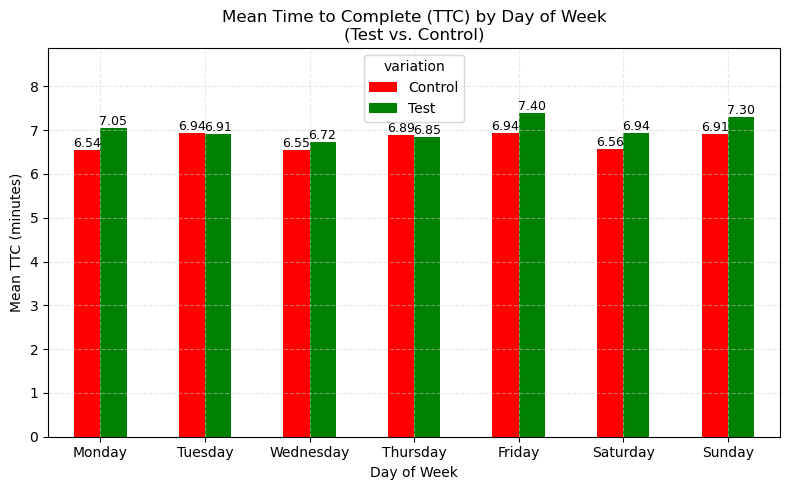

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# --------------------------------------------------
# PASO 1: Cargar el DataFrame y convertir 'date_time' a datetime
# --------------------------------------------------
df = pd.read_csv("../../data/processed/navegacion_clientes_experimento_limpio.csv")
df["date_time"] = pd.to_datetime(df["date_time"])

# --------------------------------------------------
# PASO 2: Filtrar registros relevantes: 'start' y 'confirm'
# --------------------------------------------------
df_times = df[df["process_step"].isin(["start", "confirm"])].copy()

# --------------------------------------------------
# PASO 3: Agrupar a nivel de sesión (visit_id y variation) usando groupby.apply
# --------------------------------------------------
def session_times(group):
    # Para cada grupo (una sesión), obtenemos:
    start_time = group.loc[group["process_step"] == "start", "date_time"].min()
    confirm_time = group.loc[group["process_step"] == "confirm", "date_time"].max()
    return pd.Series({"start_time": start_time, "confirm_time": confirm_time})

# Para evitar el warning, pasamos include_groups=False
df_session_times = (
    df_times.groupby(["visit_id", "variation"], as_index=False, observed=False)
            .apply(session_times, include_groups=False)
).reset_index(drop=True)

# Eliminar sesiones sin confirm_time (donde confirm_time es NaT)
df_session_times = df_session_times.dropna(subset=["confirm_time"])

# --------------------------------------------------
# PASO 4: Calcular Time to Complete (TTC) en minutos para cada sesión
# --------------------------------------------------
df_session_times["TTC_minutes"] = (
    (df_session_times["confirm_time"] - df_session_times["start_time"]).dt.total_seconds() / 60
)

# --------------------------------------------------
# PASO 5: Extraer el día de la semana a partir de start_time
# --------------------------------------------------
df_session_times["day_of_week"] = df_session_times["start_time"].dt.dayofweek
day_name_map = {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday", 4: "Friday", 5: "Saturday", 6: "Sunday"}
df_session_times["day_name"] = df_session_times["day_of_week"].map(day_name_map)

# Eliminar posibles NaN en day_name para evitar errores en la ordenación
days = [d for d in df_session_times["day_name"].unique() if pd.notna(d)]

# --------------------------------------------------
# PASO 6: Test de Hipótesis por día de la semana
# --------------------------------------------------
# Hipótesis:
#   H0: La media de TTC en Test es igual a la media de TTC en Control para ese día.
#   H1: La media de TTC en Test es menor que en Control (mejor UX: menor TTC).
alpha = 0.05

print("=== T-test para Time to Complete (TTC) por día de la semana ===\n")
for day in sorted(days, key=lambda d: list(day_name_map.values()).index(d)):
    seg = df_session_times[df_session_times["day_name"] == day]
    ttc_test = seg[seg["variation"] == "Test"]["TTC_minutes"].dropna()
    ttc_control = seg[seg["variation"] == "Control"]["TTC_minutes"].dropna()
    if len(ttc_test) == 0 or len(ttc_control) == 0:
        print(f"{day}: Datos insuficientes en Test o Control.")
        continue
    t_stat, p_two = stats.ttest_ind(ttc_test, ttc_control, equal_var=False)
    # Para test one-tailed (H1: Test < Control)
    p_one = p_two / 2 if t_stat < 0 else 1 - p_two / 2
    print(f"{day}: t-stat = {t_stat:.4f}, p-value (one-tailed) = {p_one:.6f}")
    if p_one < alpha:
        print("   -> Diferencia significativa (rechazamos H0).")
    else:
        print("   -> No hay diferencia significativa (no rechazamos H0).")
    print()

# --------------------------------------------------
# PASO 7: Graficar la media de TTC por día de la semana y grupo
# --------------------------------------------------
# Agrupar por day_name y variation para obtener la media de TTC_minutes
df_ttc_by_day = (
    df_session_times.groupby(["day_name", "variation"], as_index=False)["TTC_minutes"]
    .mean()
)

# Convertir a tabla dinámica para el gráfico
df_pivot = df_ttc_by_day.pivot(index="day_name", columns="variation", values="TTC_minutes")

# Asegurarse de que los días se ordenen correctamente
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df_pivot = df_pivot.reindex(day_order)

# Definir colores: Control en rojo, Test en verde.
color_map = {"Control": "red", "Test": "green"}
colors = [color_map.get(col, "gray") for col in df_pivot.columns]

fig, ax = plt.subplots(figsize=(8, 5))
df_pivot.plot(kind="bar", ax=ax, color=colors, legend=True)

ax.set_title("Mean Time to Complete (TTC) by Day of Week\n(Test vs. Control)")
ax.set_xlabel("Day of Week")
ax.set_ylabel("Mean TTC (minutes)")
ax.set_ylim(0, df_pivot.max().max() * 1.2)

# Añadir rejilla con líneas discontinuas grises
ax.grid(True, which='major', axis='both', color='lightgray', linestyle='--', alpha=0.5)

# Añadir etiquetas con el valor sobre cada barra
for p in ax.patches:
    height = p.get_height()
    if not np.isnan(height):
        ax.annotate(f"{height:.2f}",
                    (p.get_x() + p.get_width()/2, height),
                    ha="center", va="bottom", fontsize=9)

plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("../../img/ttc_by_day.png", dpi=300, bbox_inches='tight')
plt.show()
